In [15]:
%pip -q install mlflow boto3 awscli

Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sphinx 8.2.3 requires docutils<0.22,>=0.20, but you have docutils 0.19 which is incompatible.


In [13]:
import mlflow

mlflow.set_tracking_uri("http://ec2-54-211-18-166.compute-1.amazonaws.com:5000/")

with mlflow.start_run():
    mlflow.log_param("param1", 15)
    mlflow.log_metric("metric1", 0.89)

🏃 View run bustling-wren-346 at: http://ec2-54-211-18-166.compute-1.amazonaws.com:5000/#/experiments/0/runs/06e9df695d67482383180f13a18ae777
🧪 View experiment at: http://ec2-54-211-18-166.compute-1.amazonaws.com:5000/#/experiments/0


## Import Dependencies

In [25]:
# Data manipulation and analysis
import numpy as np
import pandas as pd
import re
from collections import Counter
import os

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix,
    precision_recall_fscore_support
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Natural Language Processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# MLflow for experiment tracking
import mlflow
import mlflow.sklearn

# AWS Services (optional - for S3 artifact storage)
import boto3

# Download required NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# Set visualization style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


## Mlflow Configuration

In [16]:
MLFLOW_TRACKING_URI = "http://ec2-54-211-18-166.compute-1.amazonaws.com:5000/"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

print(f"✓ MLflow tracking URI set to: {MLFLOW_TRACKING_URI}")

# Create or set experiment
EXPERIMENT_NAME = "RF Baseline"
mlflow.set_experiment(EXPERIMENT_NAME)

print(f"✓ MLflow experiment set to: {EXPERIMENT_NAME}")

# Test MLflow connection
print("\n--- Testing MLflow Connection ---")
try:
    with mlflow.start_run(run_name="Connection_Test") as run:
        mlflow.log_param("test_param", "connection_successful")
        mlflow.log_metric("test_metric", 1.0)
        run_id = run.info.run_id
    print(f"✓ MLflow connection successful! Run ID: {run_id}")
    print(f"  View at: {MLFLOW_TRACKING_URI}#/experiments/0/runs/{run_id}")
except Exception as e:
    print(f"✗ MLflow connection failed: {str(e)}")

✓ MLflow tracking URI set to: http://ec2-54-211-18-166.compute-1.amazonaws.com:5000/


2025/11/11 16:51:33 INFO mlflow.tracking.fluent: Experiment with name 'RF Baseline' does not exist. Creating a new experiment.


✓ MLflow experiment set to: RF Baseline

--- Testing MLflow Connection ---
🏃 View run Connection_Test at: http://ec2-54-211-18-166.compute-1.amazonaws.com:5000/#/experiments/407855132886144546/runs/5b6a09e2046a4d4ca88db854652fdaad
🧪 View experiment at: http://ec2-54-211-18-166.compute-1.amazonaws.com:5000/#/experiments/407855132886144546
✓ MLflow connection successful! Run ID: 5b6a09e2046a4d4ca88db854652fdaad
  View at: http://ec2-54-211-18-166.compute-1.amazonaws.com:5000/#/experiments/0/runs/5b6a09e2046a4d4ca88db854652fdaad


## Data Loading

In [17]:
# Load the dataset
DATA_URL = 'https://raw.githubusercontent.com/Himanshu-1703/reddit-sentiment-analysis/refs/heads/main/data/reddit.csv'
df = pd.read_csv(DATA_URL)

print(f"✓ Dataset loaded successfully")
print(f"  Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"\n  First 5 rows:")
print(df.head())

print(f"\n  Columns: {list(df.columns)}")
print(f"  Target distribution:")
print(df['category'].value_counts().sort_index())


✓ Dataset loaded successfully
  Shape: 37249 rows × 2 columns

  First 5 rows:
                                       clean_comment  category
0   family mormon have never tried explain them t...         1
1  buddhism has very much lot compatible with chr...         1
2  seriously don say thing first all they won get...        -1
3  what you have learned yours and only yours wha...         0
4  for your own benefit you may want read living ...         1

  Columns: ['clean_comment', 'category']
  Target distribution:
category
-1     8277
 0    13142
 1    15830
Name: count, dtype: int64


## Data Cleaning

In [18]:
# Store original shape
original_shape = df.shape

# Remove missing values
df.dropna(inplace=True)
print(f"✓ Removed NaN values: {original_shape[0] - df.shape[0]} rows dropped")

# Remove duplicates
before_dup = df.shape[0]
df.drop_duplicates(inplace=True)
print(f"✓ Removed duplicates: {before_dup - df.shape[0]} rows dropped")

# Remove empty or whitespace-only comments
before_empty = df.shape[0]
df = df[~(df['clean_comment'].str.strip() == '')]
print(f"✓ Removed empty comments: {before_empty - df.shape[0]} rows dropped")

print(f"\nCleaned Dataset Shape: {df.shape[0]} rows × {df.shape[1]} columns")


✓ Removed NaN values: 100 rows dropped
✓ Removed duplicates: 350 rows dropped
✓ Removed empty comments: 6 rows dropped

Cleaned Dataset Shape: 36793 rows × 2 columns


## Text Preprocessing

In [26]:
def preprocess_comment(comment):
    """
    Comprehensive text preprocessing pipeline for sentiment analysis.
    
    Steps:
    1. Convert to lowercase
    2. Remove whitespace
    3. Remove newline characters
    4. Remove non-alphanumeric characters (keep punctuation for context)
    5. Remove stopwords (but keep sentiment-important words)
    6. Lemmatize words
    
    Args:
        comment (str): Raw comment text
        
    Returns:
        str: Preprocessed comment text
    """
    # Convert to lowercase
    comment = comment.lower()
    
    # Remove trailing and leading whitespaces
    comment = comment.strip()
    
    # Remove newline characters
    comment = re.sub(r'\n', ' ', comment)
    
    # Remove non-alphanumeric characters, except punctuation
    comment = re.sub(r'[^A-Za-z0-9\s!?.,]', '', comment)
    
    # Remove stopwords but retain important ones for sentiment analysis
    stop_words = set(stopwords.words('english')) - {'not', 'but', 'however', 'no', 'yet'}
    comment = ' '.join([word for word in comment.split() if word not in stop_words])
    
    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    comment = ' '.join([lemmatizer.lemmatize(word) for word in comment.split()])
    
    return comment

# Apply preprocessing
print("Preprocessing comments...")
df['clean_comment'] = df['clean_comment'].apply(preprocess_comment)
print("✓ Preprocessing complete")

print("\nSample preprocessed comments:")
print(df[['clean_comment', 'category']].head())

# Save preprocessed data
# Define path
preprocessed_file = 'data/raw/reddit_preprocessing.csv'

# Create directories if they don't exist
os.makedirs(os.path.dirname(preprocessed_file), exist_ok=True)

# Save the preprocessed DataFrame
df.to_csv(preprocessed_file, index=False)

print(f"\n✓ Preprocessed data saved to: {preprocessed_file}")

Preprocessing comments...
✓ Preprocessing complete

Sample preprocessed comments:
                                       clean_comment  category
0  family mormon never tried explain still stare ...         1
1  buddhism much lot compatible christianity espe...         1
2  seriously say thing first get complex explain ...        -1
3  learned want teach different focus goal not wr...         0
4  benefit may want read living buddha living chr...         1

✓ Preprocessed data saved to: data/raw/reddit_preprocessing.csv


## Feature Engineering

In [27]:
# Vectorization parameters
MAX_FEATURES = 10000

print(f"Creating Bag of Words representation...")
print(f"  Vectorizer: CountVectorizer")
print(f"  Max Features: {MAX_FEATURES}")

# Initialize vectorizer
vectorizer = CountVectorizer(max_features=MAX_FEATURES)

# Transform text to feature matrix
X = vectorizer.fit_transform(df['clean_comment']).toarray()
y = df['category'].values

print(f"\n✓ Feature matrix created")
print(f"  X shape: {X.shape}")
print(f"  y shape: {y.shape}")
print(f"  Vocabulary size: {len(vectorizer.vocabulary_)}")

Creating Bag of Words representation...
  Vectorizer: CountVectorizer
  Max Features: 10000

✓ Feature matrix created
  X shape: (36793, 10000)
  y shape: (36793,)
  Vocabulary size: 10000


In [ ]:

!aws configure

## Train-Test Split

In [28]:
# Split parameters
TEST_SIZE = 0.2
RANDOM_STATE = 42

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE, 
    stratify=y
)

print(f"✓ Data split complete")
print(f"  Train size: {X_train.shape[0]} samples")
print(f"  Test size: {X_test.shape[0]} samples")
print(f"  Test ratio: {TEST_SIZE * 100}%")

print(f"\n  Train set distribution:")
unique, counts = np.unique(y_train, return_counts=True)
for label, count in zip(unique, counts):
    print(f"    Class {label:2d}: {count:5d} ({count/len(y_train)*100:.1f}%)")

print(f"\n  Test set distribution:")
unique, counts = np.unique(y_test, return_counts=True)
for label, count in zip(unique, counts):
    print(f"    Class {label:2d}: {count:5d} ({count/len(y_test)*100:.1f}%)")

✓ Data split complete
  Train size: 29434 samples
  Test size: 7359 samples
  Test ratio: 20.0%

  Train set distribution:
    Class -1:  6600 (22.4%)
    Class  0: 10217 (34.7%)
    Class  1: 12617 (42.9%)

  Test set distribution:
    Class -1:  1650 (22.4%)
    Class  0:  2555 (34.7%)
    Class  1:  3154 (42.9%)


## Model Training With Mlflow Tracking

In [29]:
# Model hyperparameters
N_ESTIMATORS = 200
MAX_DEPTH = 15

print(f"Training Random Forest Classifier...")
print(f"  n_estimators: {N_ESTIMATORS}")
print(f"  max_depth: {MAX_DEPTH}")
print(f"  random_state: {RANDOM_STATE}")

# Start MLflow run
with mlflow.start_run(run_name="RandomForest_Baseline_TrainTestSplit") as run:
    
    # Log tags for experiment organization
    mlflow.set_tag("experiment_type", "baseline")
    mlflow.set_tag("model_type", "RandomForestClassifier")
    mlflow.set_tag("description", 
                   "Baseline RandomForest model for sentiment analysis using Bag of Words (BoW) with train-test split")
    
    # Log vectorizer parameters
    mlflow.log_param("vectorizer_type", "CountVectorizer")
    mlflow.log_param("vectorizer_max_features", MAX_FEATURES)
    mlflow.log_param("test_size", TEST_SIZE)
    mlflow.log_param("random_state", RANDOM_STATE)
    
    # Log model hyperparameters
    mlflow.log_param("n_estimators", N_ESTIMATORS)
    mlflow.log_param("max_depth", MAX_DEPTH)
    
    # Initialize and train the model
    print("\n  Training model...")
    model = RandomForestClassifier(
        n_estimators=N_ESTIMATORS, 
        max_depth=MAX_DEPTH, 
        random_state=RANDOM_STATE
    )
    model.fit(X_train, y_train)
    print("  ✓ Model trained successfully")
    
    # Make predictions
    print("\n  Making predictions...")
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    
    # Calculate metrics
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_pred)
    
    # Log accuracy metrics
    mlflow.log_metric("train_accuracy", train_accuracy)
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("accuracy", test_accuracy)  # For backward compatibility
    
    print(f"  ✓ Train Accuracy: {train_accuracy:.4f}")
    print(f"  ✓ Test Accuracy: {test_accuracy:.4f}")
    
    # Detailed classification report
    classification_rep = classification_report(y_test, y_pred, output_dict=True)
    
    # Log metrics for each class
    for label, metrics in classification_rep.items():
        if isinstance(metrics, dict):  # For precision, recall, f1-score per class
            for metric, value in metrics.items():
                mlflow.log_metric(f"{label}_{metric}", value)

Training Random Forest Classifier...
  n_estimators: 200
  max_depth: 15
  random_state: 42

  Training model...
  ✓ Model trained successfully

  Making predictions...
  ✓ Train Accuracy: 0.6604
  ✓ Test Accuracy: 0.6478
🏃 View run RandomForest_Baseline_TrainTestSplit at: http://ec2-54-211-18-166.compute-1.amazonaws.com:5000/#/experiments/407855132886144546/runs/f1479e3acef64c4697b13050343275f3
🧪 View experiment at: http://ec2-54-211-18-166.compute-1.amazonaws.com:5000/#/experiments/407855132886144546


## Visualizations and Artifacts


  Creating visualizations...


S3UploadFailedError: Failed to upload model_evaluation_dashboard.png to mlfow-bucket-2025/407855132886144546/0d460f2030e94f4d88a1486e43e0c731/artifacts/model_evaluation_dashboard.png: An error occurred (AccessDenied) when calling the PutObject operation: Access Denied

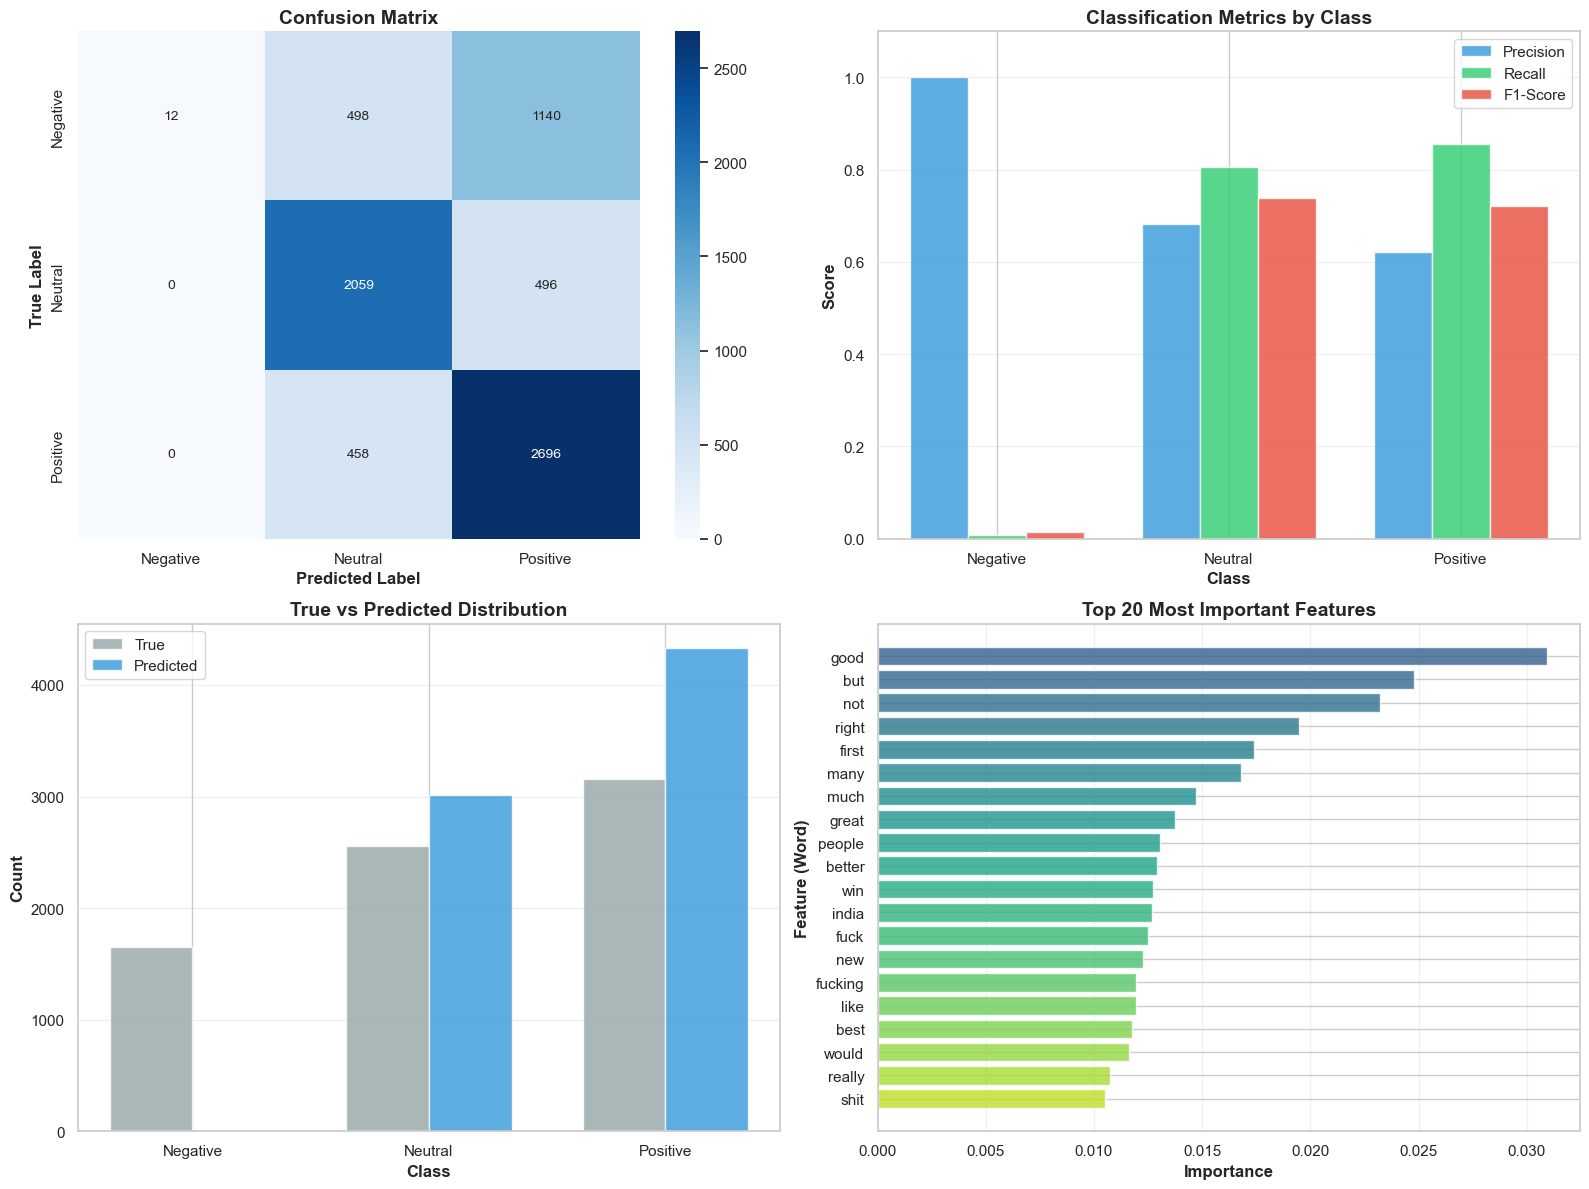

In [30]:
print("\n  Creating visualizations...")
    
    # Create a comprehensive figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=axes[0, 0],
                xticklabels=['Negative', 'Neutral', 'Positive'],
                yticklabels=['Negative', 'Neutral', 'Positive'])
axes[0, 0].set_xlabel("Predicted Label", fontweight='bold')
axes[0, 0].set_ylabel("True Label", fontweight='bold')
axes[0, 0].set_title("Confusion Matrix", fontsize=14, fontweight='bold')
    
    # 2. Classification Metrics by Class
classes = [-1, 0, 1]
class_names = ['Negative', 'Neutral', 'Positive']
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, labels=classes)
    
x = np.arange(len(class_names))
width = 0.25
    
axes[0, 1].bar(x - width, precision, width, label='Precision', alpha=0.8, color='#3498db')
axes[0, 1].bar(x, recall, width, label='Recall', alpha=0.8, color='#2ecc71')
axes[0, 1].bar(x + width, f1, width, label='F1-Score', alpha=0.8, color='#e74c3c')
    
axes[0, 1].set_xlabel('Class', fontweight='bold')
axes[0, 1].set_ylabel('Score', fontweight='bold')
axes[0, 1].set_title('Classification Metrics by Class', fontsize=14, fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(class_names)
axes[0, 1].legend()
axes[0, 1].set_ylim(0, 1.1)
axes[0, 1].grid(axis='y', alpha=0.3)
    
    # 3. Prediction Distribution
pred_counts = pd.Series(y_pred).value_counts().sort_index()
true_counts = pd.Series(y_test).value_counts().sort_index()
    
x = np.arange(len(class_names))
width = 0.35
    
axes[1, 0].bar(x - width/2, true_counts.values, width, label='True', alpha=0.8, color='#95a5a6')
axes[1, 0].bar(x + width/2, pred_counts.values, width, label='Predicted', alpha=0.8, color='#3498db')
    
axes[1, 0].set_xlabel('Class', fontweight='bold')
axes[1, 0].set_ylabel('Count', fontweight='bold')
axes[1, 0].set_title('True vs Predicted Distribution', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(class_names)
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)
    
    # 4. Feature Importance (Top 20)
feature_importance = pd.DataFrame({
        'feature': vectorizer.get_feature_names_out(),
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False).head(20)
    
colors_gradient = plt.cm.viridis(np.linspace(0.3, 0.9, len(feature_importance)))
axes[1, 1].barh(range(len(feature_importance)), feature_importance['importance'].values, 
                    color=colors_gradient, alpha=0.8)
axes[1, 1].set_yticks(range(len(feature_importance)))
axes[1, 1].set_yticklabels(feature_importance['feature'].values)
axes[1, 1].set_xlabel('Importance', fontweight='bold')
axes[1, 1].set_ylabel('Feature (Word)', fontweight='bold')
axes[1, 1].set_title('Top 20 Most Important Features', fontsize=14, fontweight='bold')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(axis='x', alpha=0.3)
    
plt.tight_layout()
    
    # Save and log the comprehensive figure
viz_path = "model_evaluation_dashboard.png"
plt.savefig(viz_path, dpi=150, bbox_inches='tight')
mlflow.log_artifact(viz_path)
print(f"  ✓ Saved visualization: {viz_path}")
plt.show()
    
    # Save individual confusion matrix for quick reference
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Negative', 'Neutral', 'Positive'],
                yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel("Predicted Label", fontweight='bold')
plt.ylabel("True Label", fontweight='bold')
plt.title("Confusion Matrix", fontsize=14, fontweight='bold')
plt.tight_layout()
    
confusion_path = "confusion_matrix.png"
plt.savefig(confusion_path, dpi=150, bbox_inches='tight')
mlflow.log_artifact(confusion_path)
print(f"  ✓ Saved confusion matrix: {confusion_path}")
plt.close()
    
    # Log the trained model
print("\n  Logging model to MLflow...")
mlflow.sklearn.log_model(model, "random_forest_model")
print("  ✓ Model logged successfully")
    
    # Log the preprocessed dataset
print("\n  Logging dataset artifact...")
mlflow.log_artifact(preprocessed_file)
print(f"  ✓ Dataset logged: {preprocessed_file}")
    
    # Get run information
run_id = run.info.run_id
experiment_id = run.info.experiment_id
    
print("\n" + "=" * 80)
print("MLFLOW RUN COMPLETED")
print("=" * 80)
print(f"  Run ID: {run_id}")
print(f"  Experiment ID: {experiment_id}")
print(f"  View run at: {MLFLOW_TRACKING_URI}#/experiments/{experiment_id}/runs/{run_id}")
